<IPython.core.display.Javascript object>


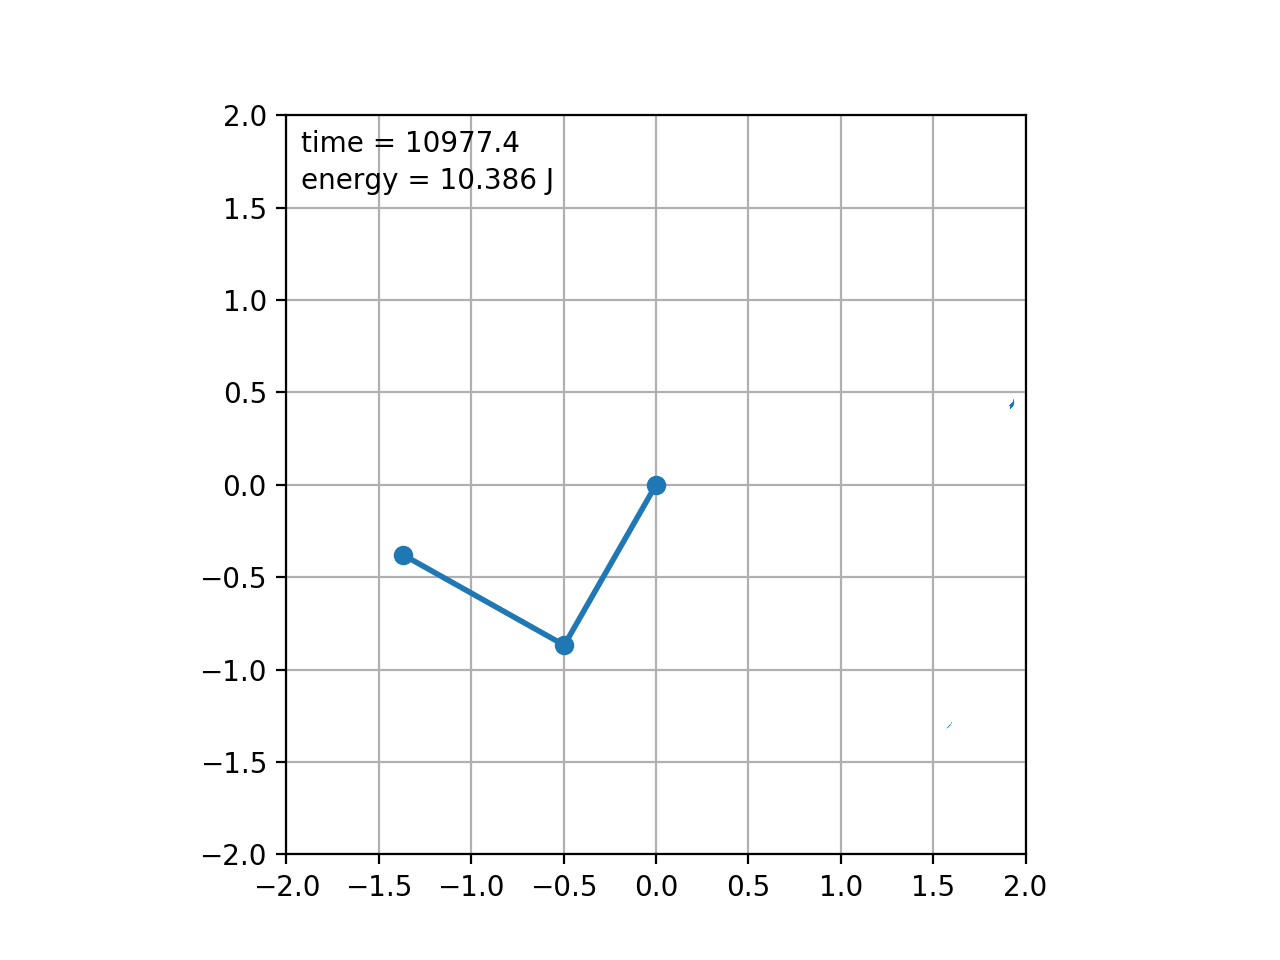

In [1]:

# General Numerical Solver for the 1D Time-Dependent Schrodinger's equation.

# adapted from code at http://matplotlib.sourceforge.net/examples/animation/double_pendulum_animated.py

# Double pendulum formula translated from the C code at
# http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

# author: Jake Vanderplas
# email: vanderplas@astro.washington.edu
# website: http://jakevdp.github.com
# license: BSD
# Please feel free to use and modify this, but keep the above information. Thanks!
# """
%matplotlib notebook
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class DoublePendulum:
    """Double Pendulum Class

    init_state is [theta1, omega1, theta2, omega2] in degrees,
    where theta1, omega1 is the angular position and velocity of the first
    pendulum arm, and theta2, omega2 is that of the second pendulum arm
    """
    def __init__(self,
                 init_state = [120, 0, -20, 0],
                 L1=1.0,  # length of pendulum 1 in m
                 L2=1.0,  # length of pendulum 2 in m
                 M1=1.0,  # mass of pendulum 1 in kg
                 M2=1.0,  # mass of pendulum 2 in kg
                 G=9.8,  # acceleration due to gravity, in m/s^2
                 origin=(0, 0)): 
        self.init_state = np.asarray(init_state, dtype='float')
        self.params = (L1, L2, M1, M2, G)
        self.origin = origin
        self.time_elapsed = 0

        self.state = self.init_state * np.pi / 180.
    
    def position(self):
        """compute the current x,y positions of the pendulum arms"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([self.origin[0],
                       L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                       -L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        return (x, y)

    def energy(self):
        """compute the energy of the current state"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([-L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        vx = np.cumsum([L1 * self.state[1] * cos(self.state[0]),
                        L2 * self.state[3] * cos(self.state[2])])
        vy = np.cumsum([L1 * self.state[1] * sin(self.state[0]),
                        L2 * self.state[3] * sin(self.state[2])])

        U = G * (M1 * y[0] + M2 * y[1])
        K = 0.5 * (M1 * np.dot(vx, vx) + M2 * np.dot(vy, vy))

        return U + K

    def dstate_dt(self, state, t):
        """compute the derivative of the given state"""
        (M1, M2, L1, L2, G) = self.params

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[2] = state[3]

        cos_delta = cos(state[2] - state[0])
        sin_delta = sin(state[2] - state[0])

        den1 = (M1 + M2) * L1 - M2 * L1 * cos_delta * cos_delta
        dydx[1] = (M2 * L1 * state[1] * state[1] * sin_delta * cos_delta
                   + M2 * G * sin(state[2]) * cos_delta
                   + M2 * L2 * state[3] * state[3] * sin_delta
                   - (M1 + M2) * G * sin(state[0])) / den1

        den2 = (L2 / L1) * den1
        dydx[3] = (-M2 * L2 * state[3] * state[3] * sin_delta * cos_delta
                   + (M1 + M2) * G * sin(state[0]) * cos_delta
                   - (M1 + M2) * L1 * state[1] * state[1] * sin_delta
                   - (M1 + M2) * G * sin(state[2])) / den2
        
        return dydx

    def step(self, dt):
        """execute one time step of length dt and update state"""
        self.state = integrate.odeint(self.dstate_dt, self.state, [0, dt])[1]
        self.time_elapsed += dt

#------------------------------------------------------------
# set up initial state and global variables
pendulum = DoublePendulum([180., 0.0, -20., 0.0])
dt = 1./30 # 30 fps

#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    """perform animation step"""
    global pendulum, dt
    pendulum.step(dt)
    
    line.set_data(*pendulum.position())
    time_text.set_text('time = %.1f' % pendulum.time_elapsed)
    energy_text.set_text('energy = %.3f J' % pendulum.energy())
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)

ani = animation.FuncAnimation(fig, animate, frames=300,
                              interval=interval, blit=True, init_func=init)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#ani.save('double_pendulum.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()